In [ ]:
import numpy as np
from STMiner import SPFinder

sp = SPFinder()
# sp1 = SPFinder()
# sp2 = SPFinder()
# sp.read_h5ad(file='F://GSM6177599_10xVisium.h5ad',bin_size=1)
# sp.read_h5ad(file='I://zebrafish/10X_Visium_hunter2021spatially_sample_C_data.h5ad',bin_size=1)
# sp.read_h5ad(file='F://空间转录组数据/MOUSE/V1_Adult_Mouse_Brain_filtered_feature_bc_matrix.h5',bin_size=50)
sp.read_h5ad(file='G://5DPI_1.h5ad', bin_size=50)
# sp1.read_h5ad(file='G://5DPI_2.h5ad', bin_size=50)
# sp2.read_h5ad(file='G://5DPI_3.h5ad', bin_size=50)

In [ ]:
import numpy as np
from STMiner import SPFinder
sp_fish = SPFinder()
sp_fish.read_h5ad(file='I://zebrafish/10X_Visium_hunter2021spatially_sample_C_data.h5ad',bin_size=1)
sp_fish.get_genes_csr_array(min_cells=200, log1p=False)
sp_fish.spatial_high_variable_genes()

Computing ot distances...:  18%|█▊        | 1138/6262 [06:25<52:55,  1.61it/s]  

In [3]:
sp_fish.fit_pattern(n_comp=20,gene_list=list(sp_fish.global_distance['Gene'][:500]))
sp_fish.cluster_gene(n_clusters=6)

Fitting GMM...: 100%|██████████| 500/500 [01:58<00:00,  4.22it/s]


AttributeError: 'NoneType' object has no attribute 'index'

In [1]:
import numpy as np
from STMiner import SPFinder
sp_fish = SPFinder()
sp_fish.read_h5ad(file='I://zebrafish/10X_Visium_hunter2021spatially_sample_C_data.h5ad',bin_size=1)

In [8]:
list(sp_fish.global_distance['Gene'][:1000])

['myha',
 'pvalb1',
 'zgc:101560',
 'vmhcl',
 'pvalb2',
 'myhc4',
 'cmlc1',
 'si:dkey-193p11.2',
 'actc1a',
 'myl7',
 'gstk2',
 'pvalb3',
 'pln',
 'tnnt2a',
 'tnni2a.3',
 'gstk4',
 'tnnc1a',
 'actn3a',
 'pvalb4',
 'nppb',
 'gamt',
 'mybpc3',
 'acta1b',
 'tnni1b',
 'mb',
 'rbpms2b',
 'fabp1b.2',
 'ckmt2a',
 'synpo2la',
 'CABZ01078594.1',
 'slc8a1a',
 'igfn1.1',
 'sbk3',
 'nppa',
 'si:ch211-63p21.8',
 'slc25a4',
 'atp2a1l',
 'si:dkey-56e3.2',
 'alpk3a',
 'klhl31',
 'myom1b',
 'pabpc4',
 'mylk4a',
 'ckmt2b',
 'FO704821.1',
 'ttn.1',
 'bves',
 'prr33',
 'si:ch1073-221c23.2',
 'si:dkey-211f22.5',
 'ryr3',
 'chrne',
 'pdlim5a',
 'tnni2b.2',
 'kcnh6a',
 'TPM1',
 'smyd1a',
 'si:ch211-284f22.3',
 'txlnba',
 'tmod4',
 'tmem38a',
 'tmem41ab',
 'tpm4a',
 'nr4a3',
 'si:ch211-255p10.3',
 'myoz1a',
 'nmrk2',
 'myhz1.1-1',
 'si:ch73-367p23.2',
 'si:ch211-69b7.6',
 'obsl1b',
 'fbxo32',
 'atp1a2a',
 'slc38a3b',
 'psme4a',
 'alpk2',
 'ldb3a',
 'pfkma',
 'myom2a',
 'cox7a1',
 'calcoco1b',
 'si:ch211-266g1

In [23]:
import pandas as pd

sc = pd.read_csv('E://sc_data_F_top2000_gene.csv')


Text(0.5, 1.0, 'High variable genes')

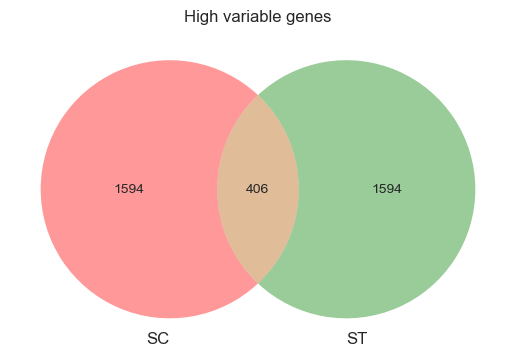

In [28]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt 

venn2([set(sc['x']),set(sp_fish.global_distance['Gene'][:2000])], set_labels=['SC', 'ST'])
plt.title('High variable genes')

(-3.1500000000000004, 66.15, -6.3500000000000005, 133.35)

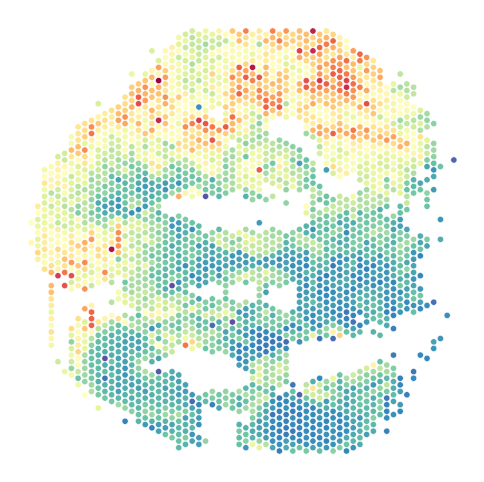

In [38]:
from scipy.sparse import csr_matrix
import seaborn as sns
def _adjust_arr(arr, rotate, reverse_x, reverse_y):
    if rotate:
        arr = np.rot90(arr)
    if reverse_y:
        arr = np.flipud(arr)
    if reverse_x:
        arr = np.fliplr(arr)
    return arr

data = np.array(sp_fish.adata.X.sum(axis=1)).flatten()
row_indices = np.array(sp_fish.adata.obs['x'].values).flatten()
column_indices = np.array(sp_fish.adata.obs['y'].values).flatten()
global_matrix = csr_matrix((data, (row_indices, column_indices)))
global_matrix = _adjust_arr(global_matrix.todense(), True, True, False)
global_matrix = csr_matrix(global_matrix)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
sns.scatterplot(x=global_matrix.nonzero()[1],
                y=global_matrix.nonzero()[0],
                s=20,
                cmap='Spectral_r',
                c=global_matrix.data)
plt.axis('off')

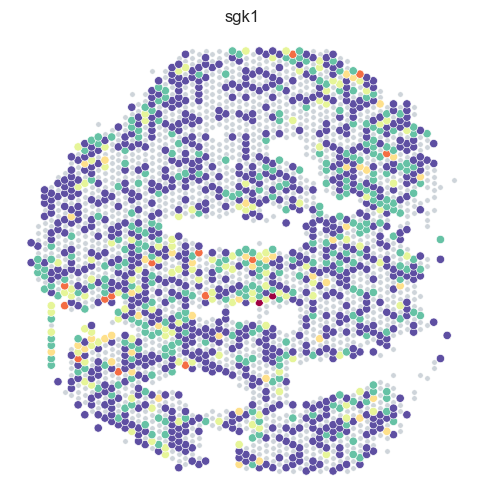

In [27]:
sp_fish.plot.plot_gene('sgk1', figsize=(6, 6), rotate=True, reverse_x=True)

In [221]:
sp1 = SPFinder()
sp1.read_h5ad(file='G://5DPI_2.h5ad', bin_size=50)
sp1.get_genes_csr_array(min_cells=500, log1p=False)
sp1.spatial_high_variable_genes()
sp1.fit_pattern(n_comp=20,gene_list=list(sp1.global_distance['Gene'][:500]))
sp1.build_distance_array(method='gmm')

Building distance array...: 100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


In [248]:
sp2 = SPFinder()
sp2.read_h5ad(file='G://5DPI_3.h5ad', bin_size=50)
sp2.get_genes_csr_array(min_cells=500, log1p=False)
sp2.spatial_high_variable_genes()
sp2.fit_pattern(n_comp=20,gene_list=list(sp2.global_distance['Gene'][:500]))
sp2.build_distance_array(method='gmm')

Building distance array...: 100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


In [ ]:
sp.get_genes_csr_array(min_cells=500, log1p=False)

In [ ]:
import pickle
with open('aaa.pkl', 'wb') as file:
    pickle.dump(sp.csr_dict, file)

In [ ]:
import pickle
with open('aaa.pkl', 'rb') as file:
    sp.csr_dict = pickle.load(file)

In [200]:
sp.spatial_high_variable_genes()

Computing distances...: 100%|██████████| 7299/7299 [2:02:35<00:00,  1.01s/it]  


In [ ]:
with open('bbb.pkl', 'wb') as file:
    pickle.dump(sp.global_distance, file)

In [ ]:
with open('bbb.pkl', 'rb') as file:
    sp.global_distance = pickle.load(file)

In [322]:
sp.fit_pattern(n_comp=20,gene_list=list(sp.global_distance['Gene'][:1000]))

Fitting GMM...:   1%|▏         | 13/1000 [00:06<07:53,  2.09it/s]


KeyboardInterrupt: 

In [203]:
sp.build_distance_array(method='gmm')

Building distance array...: 100%|██████████| 500/500 [03:29<00:00,  2.38it/s]


In [ ]:
sp.build_distance_array(method='ot', gene_list=list(sp.global_distance['Gene'][:100]))

In [ ]:
sp.plot.plot_gene('AMEX60DD003045', spot_size=15, rotate=True, reverse_x=False, log1p=True)

In [ ]:
from scipy.sparse import csr_matrix
import seaborn as sns

data = np.array(sp.adata.X.sum(axis=1)).flatten()
row_indices = np.array(sp.adata.obs['x'].values).flatten()
column_indices = np.array(sp.adata.obs['y'].values).flatten()
global_matrix = csr_matrix((data, (row_indices, column_indices)))
global_matrix = np.rot90(global_matrix.todense())
global_matrix = csr_matrix((global_matrix))
sns.scatterplot(x=global_matrix.nonzero()[1],
                y=global_matrix.nonzero()[0],
                s=15,
                color='#ced4da')
sp.plot.plot_gene('LOC115084076[nr]|SCN5A[hs] | AMEX60DD021356', spot_size=15, rotate=True, reverse_x=False, log1p=True)


<Axes: xlabel='Distance', ylabel='Count'>

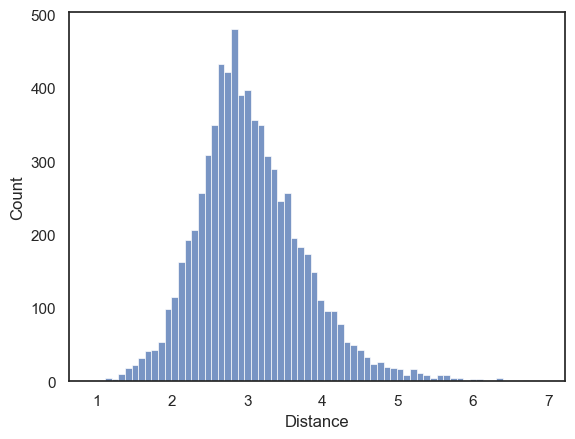

In [204]:
import seaborn as sns
sns.histplot(np.log1p(sp.global_distance['Distance']))

In [212]:
sp.cluster_gene(n_clusters=5)

In [222]:
sp1.cluster_gene(n_clusters=5)

In [250]:
sp2.cluster_gene(n_clusters=5)

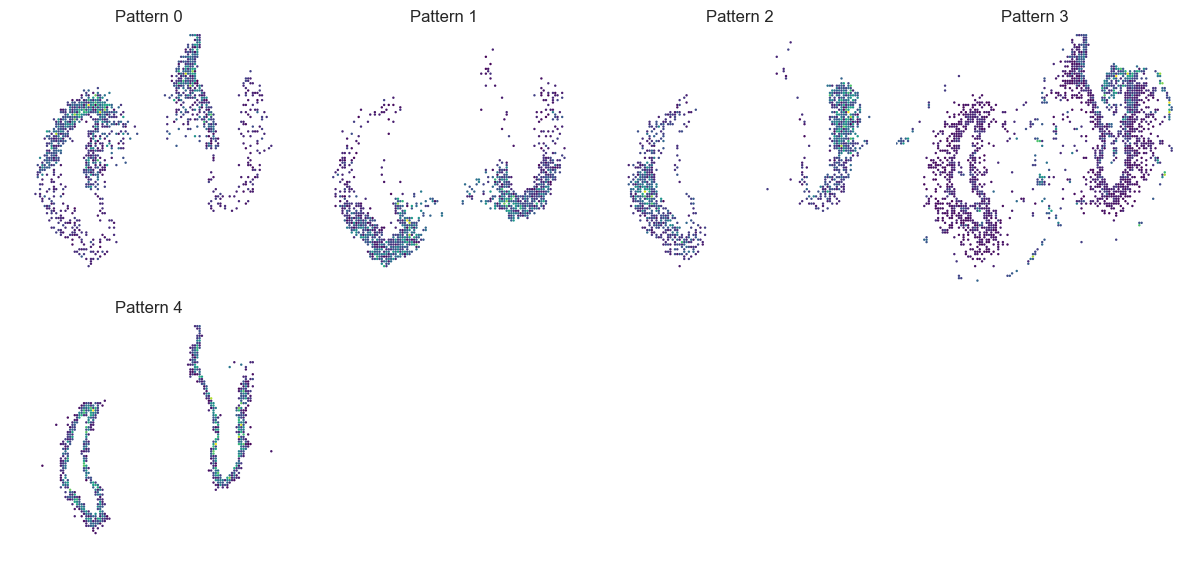

In [410]:
sp2.get_pattern_array(vote_rate=0.3)
sp2.plot.plot_pattern(heatmap=False, reverse_x=True, reverse_y=False, s=3, vmax=99,output_path='./sp2_pattern')


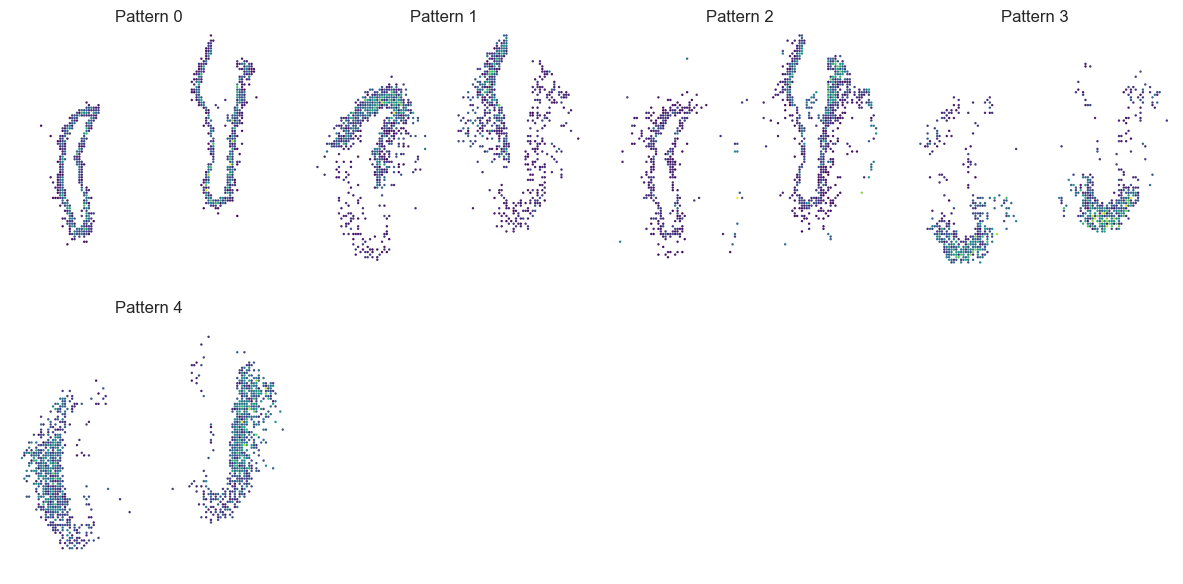

In [411]:
sp1.get_pattern_array(vote_rate=0.3)
sp1.plot.plot_pattern(heatmap=False, reverse_x=True, reverse_y=False, s=3, vmax=99,output_path='./sp1_pattern')


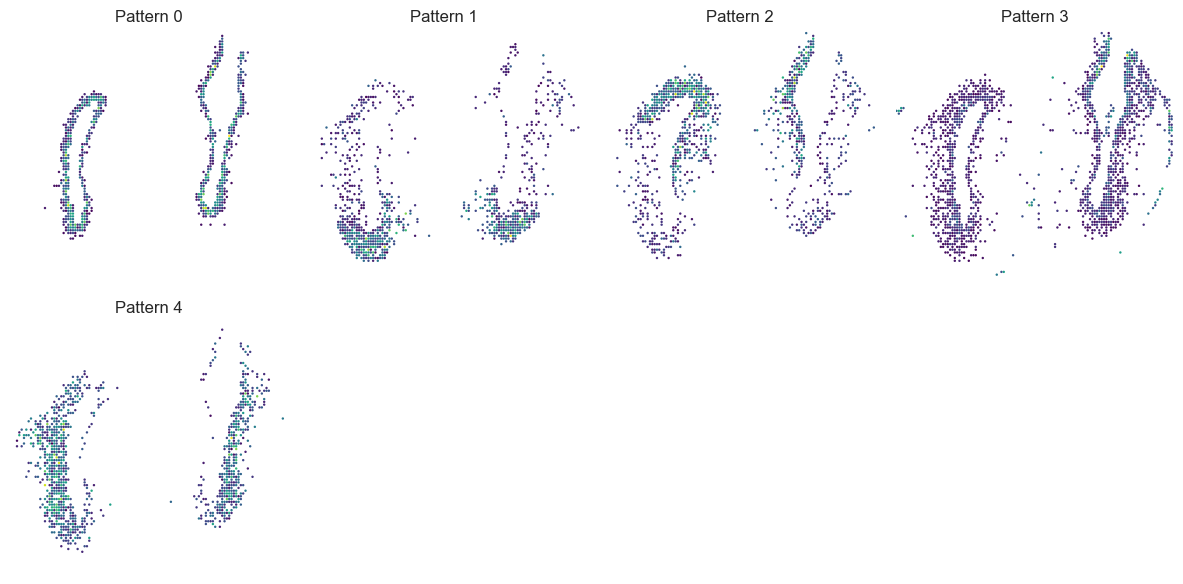

In [409]:

sp.get_pattern_array(vote_rate=0.3)
sp.plot.plot_pattern(heatmap=False, reverse_x=True, reverse_y=False, s=3, vmax=99,output_path='./sp_pattern')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


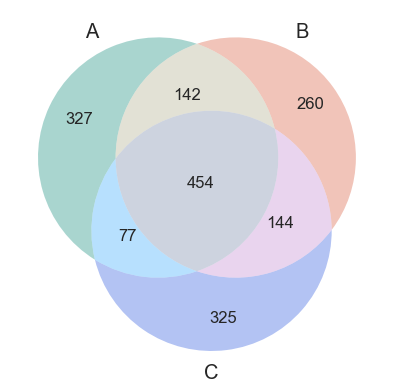

In [423]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
intersection = set(sp.genes_labels['gene_id']) & set(sp1.genes_labels['gene_id']) & set(sp2.genes_labels['gene_id'])

l1 = list(
    (sp.genes_labels[sp.genes_labels['gene_id'].isin(intersection) & (sp.genes_labels['labels'] == 0)])['gene_id'])
l2 = list(
    (sp1.genes_labels[sp1.genes_labels['gene_id'].isin(intersection) & (sp1.genes_labels['labels'] == 0)])['gene_id'])
l3 = list(
    (sp2.genes_labels[sp2.genes_labels['gene_id'].isin(intersection) & (sp2.genes_labels['labels'] == 4)])['gene_id'])

v = venn3([set(sp.global_distance['Gene'][:1000]),
           set(sp1.global_distance['Gene'][:1000]),
           set(sp2.global_distance['Gene'][:1000])],
          set_colors=['#2a9789','#dc6c50','royalblue'])
plt.savefig('aaa.eps', dpi=1000, format='eps')

In [406]:
454/1000

0.454

In [25]:
sp.plot.plot_genes(label=0,rotate=True,reverse_y=True)

NameError: name 'sp' is not defined

In [383]:
sp.genes_labels[sp.genes_labels['gene_id'] == 'TGFBI | AMEX60DDU001002594']

,gene_id,labels
58,TGFBI | AMEX60DDU001002594,3


In [365]:
list((sp2.genes_labels[sp2.genes_labels['gene_id'].isin(intersection) & (sp2.genes_labels['labels']==0)])['gene_id'])

['NMB | AMEX60DD003796',
 'PARPI_0012952[nr]|C1QL3[hs] | AMEX60DD022116',
 'BDNF[hs] | AMEX60DD004949',
 'SLC26A5 | AMEX60DD006403',
 'LOC115086130[nr]|NEUROD6[hs] | AMEX60DD037990',
 'NEUROD2 | AMEX60DD010297',
 'MAG | AMEX60DD016175',
 'AVP[hs] | AMEX60DD046200',
 'TMIE | AMEX60DD020531',
 'LOC109111278[nr] | AMEX60DD016836',
 'BHLHE22 | AMEX60DD039815',
 'RTN4RL2 | AMEX60DD007349',
 'LOC108714081[nr]|KCNG4[hs] | AMEX60DD017199',
 'ADCYAP1 | AMEX60DD039450',
 'CPLX3 | AMEX60DD003990',
 'ZBTB18 | AMEX60DD035280',
 'LOC115462554[nr]|EMX1[hs] | AMEX60DD046284',
 'NPTX2 | AMEX60DD025890',
 'EGFL6 | AMEX60DD048505',
 'MEGF11 | AMEX60DD004221',
 'LOC113746826[nr]|LRRC75B[hs] | AMEX60DD000436',
 'NR2F1 | AMEX60DD042580',
 'RASGRP2 | AMEX60DD025253',
 'SMOC2 | AMEX60DD034577',
 'SLC17A7.S[nr]|SLC17A6[hs] | AMEX60DD016391',
 'ADAM8 | AMEX60DD052283',
 'RHBDF2 | AMEX60DD030803',
 'NTNG1 | AMEX60DD019201',
 'AMEX60DD010157',
 'PDZD2 | AMEX60DD041840',
 'CHGB | AMEX60DD035704',
 'ECM1 | AMEX60DD

In [370]:
intersection

{'AB205_0026330[nr]|ISYNA1[hs] | AMEX60DD014135',
 'AB205_0156120[nr]|KRT19[hs] | AMEX60DD010100',
 'ADAM8 | AMEX60DD052283',
 'ADAMTS8[nr] | AMEX60DD053568',
 'ADCYAP1 | AMEX60DD039450',
 'AHCYL1 | AMEX60DD009236',
 'AIF1 | AMEX60DD010609',
 'AMEX60DD004787',
 'AMEX60DD004976',
 'AMEX60DD010157',
 'AMEX60DD010632',
 'AMEX60DD015376',
 'AMEX60DD018337',
 'AMEX60DD022072',
 'AMEX60DD024011',
 'AMEX60DD034076',
 'AMEX60DD038908',
 'AMEX60DD048202',
 'AMEX60DD049521',
 'AMEX60DD050509',
 'AMEX60DD053567',
 'AMEX60DDU001001926',
 'AMEX60DDU001038372',
 'ANXA1.2.S[nr]|ANXA1[hs] | AMEX60DD043188',
 'ANXA2 | AMEX60DD005352',
 'APOC1[nr] | AMEX60DD018145',
 'AQP4 | AMEX60DD039570',
 'ASAH1 | AMEX60DD045450',
 'ASS1[hs] | AMEX60DD050366',
 'AVP[hs] | AMEX60DD046200',
 'B2M | AMEX60DD028300',
 'BAIAP3 | AMEX60DD020653',
 'BDNF[hs] | AMEX60DD004949',
 'BHLHE22 | AMEX60DD039815',
 'BRS3 | AMEX60DD037454',
 'BTBD17 | AMEX60DD031293',
 'C1QB | AMEX60DD052070',
 'CA14 | AMEX60DD015105',
 'CALB2 | AME

In [311]:
len(l3)

134

In [302]:
set(l1)

{'AB205_0026330[nr]|ISYNA1[hs] | AMEX60DD014135',
 'AB205_0156120[nr]|KRT19[hs] | AMEX60DD010100',
 'ADAMTS8[nr] | AMEX60DD053568',
 'AMEX60DD004787',
 'AMEX60DD017847',
 'AMEX60DD030318',
 'AMEX60DD053567',
 'AQP4 | AMEX60DD039570',
 'CA14 | AMEX60DD015105',
 'CD99[nr] | AMEX60DD048204',
 'CHRDL1 | AMEX60DD037123',
 'CLIC1 | AMEX60DD010724',
 'CLIC4 | AMEX60DD005778',
 'COL18A1[nr] | AMEX60DD055544',
 'CRIP1 | AMEX60DD011997',
 'DDT | AMEX60DD000400',
 'DR999_PMT13074[nr] | AMEX60DD021318',
 'EFHD1 | AMEX60DD002616',
 'EZR[nr] | AMEX60DD035181',
 'FABP7[nr] | AMEX60DD034100',
 'FGFBP3 | AMEX60DD052589',
 'FZD2 | AMEX60DD009877',
 'GAS1 | AMEX60DD043077',
 'GJA1 | AMEX60DD034120',
 'GLIS2[nr] | AMEX60DD020297',
 'GNG5 | AMEX60DD019042',
 'GOLIM4 | AMEX60DD001761',
 'LOC101937948[nr] | AMEX60DD018211',
 'LOC101953989[nr] | AMEX60DD010803',
 'LOC104309823[nr]|CYP27C1[hs] | AMEX60DD056196',
 'LOC107323479[nr]|HES5[hs] | AMEX60DD051351',
 'LOC108785856[nr] | AMEX60DD054853',
 'LOC112116036

In [298]:
sp1.genes_labels[sp.genes_labels['labels']==0]['gene_id']

1                              RRM2[hs] | AMEX60DD033253
9                      LOC112114046[nr] | AMEX60DD051097
18            LOC115076503[nr]|C1QA[hs] | AMEX60DD052072
30                                 NTN1 | AMEX60DD030673
37                                 C1QB | AMEX60DD052070
                             ...                        
460    LOC104012646[nr]|LOC107985021[hs] | AMEX60DD00...
477                              INAFM2 | AMEX60DD011530
478    LOC115079518[nr]|C11ORF96[hs] | AMEX60DDU00100...
489                     ROHU_025827[nr] | AMEX60DD010987
492                               UNC5D | AMEX60DD002483
Name: gene_id, Length: 66, dtype: object

In [266]:
sp.patterns_matrix_dict

{0: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 1: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 2: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 3: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

In [ ]:
sp.plot.plot_genes(label=4, vmax=99)

In [ ]:
import seaborn as sns
from STMiner.Algorithm.AlgUtils import get_exp_array
from scipy.sparse import csr_matrix
# sns.heatmap(csr_matrix_example.todense())

sp.plot.plot_gene('BRAFhuman', spot_size=20, rotate=True)

In [ ]:
name = 'pax3a'
row_indices = np.array(sp.adata[:,name].obs['x'].values).flatten()
column_indices = np.array(sp.adata[:,name].obs['y'].values).flatten()
data = np.array(sp.adata[:,name].X.todense()).flatten()
gene = csr_matrix((data, (row_indices, column_indices)))

In [ ]:
sp.plot.plot_genes(label=0, vmax=99, rotate=True, reverse_y=True)

In [ ]:
sp.plot.plot_tsne()

In [ ]:

row_indices = np.array(sp.adata[:,'CCK | AMEX60DD022038'].obs['x'].values).flatten()
column_indices = np.array(sp.adata[:,'CCK | AMEX60DD022038'].obs['y'].values).flatten()
data = np.array(sp.adata[:,'CCK | AMEX60DD022038'].X.todense()).flatten()
gene = csr_matrix((data, (row_indices, column_indices)))

In [ ]:
np.array(sp.adata[:,'CCK | AMEX60DD022038'].X.todense()).flatten()

In [ ]:
import pandas as pd

df = pd.DataFrame(sp.adata.X.todense())
df.index = sp.adata.obs['x'].astype(str) + 'x' + sp.adata.obs['y'].astype(str)
df.columns = sp.adata.var.index
df.T.to_csv('count.csv')

In [ ]:
sp.flush_app()
sp.app.run()

In [ ]:
sp.load_marked_image('')

In [ ]:
# gene_list=list(sp.adata.var.nlargest(700, 'dispersions_norm').index)
gene_list=list(sp.adata.var.index)
sp.build_distance_array(method='cs', gene_list=gene_list)

In [ ]:
sp.fit_pattern(n_comp=20, min_cells=200, n_top_genes=200, remove_low_exp_spots=False)
# sp1.fit_pattern(n_comp=20, min_cells=200, n_top_genes=500, remove_low_exp_spots=False)
# sp2.fit_pattern(n_comp=20, min_cells=200, n_top_genes=500, remove_low_exp_spots=False)

In [ ]:
sp.build_distance_array(method='ot')
# sp1.build_distance_array()
# sp2.build_distance_array()

In [ ]:
import pickle
with open('da_dip5_2_h200_t100.pkl', 'wb') as file:
    pickle.dump(sp.genes_distance_array, file)

In [ ]:
import pickle
with open('da.pkl', 'rb') as file:
    sp.genes_distance_array = pickle.load(file)
sp.cluster_gene(n_clusters=6, mds_components=20, use_highly_variable_gene=False, n_top_genes=800)

In [ ]:
sp.cluster_gene(n_clusters=5, mds_components=20, use_highly_variable_gene=False, n_top_genes=400)
# sp1.cluster_gene(n_clusters=5, mds_components=20, use_highly_variable_gene=False, n_top_genes=400)
# sp2.cluster_gene(n_clusters=5, mds_components=20, use_highly_variable_gene=False, n_top_genes=400)

In [ ]:
sp.cluster_gene(n_clusters=8, mds_components=20, use_highly_variable_gene=False, n_top_genes=500)
sp.get_pattern_array(vote_rate=0.3)

In [ ]:
sp.get_pattern_array(vote_rate=0.3)
# sp1.get_pattern_array(vote_rate=0.25)
# sp2.get_pattern_array(vote_rate=0.3)

In [ ]:
sp.plot.plot_pattern(vmax=99,
                     heatmap=False,
                     s=3,
                     reverse_y=True,
                     reverse_x=True,
                     image_path='E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png',
                     rotate_img=False, 
                     # k=3,
                     aspect=0.55,                    
                     output_path='./'
                     )

In [ ]:
sp.plot.plot_intersection(pattern_list=[0,1],
                          image_path='E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png',
                          reverse_y=True,
                          reverse_x=True,
                          aspect=0.55,
                          s=20)

In [ ]:
sp1.plot.plot_pattern(vmax=99,
                     heatmap=False,
                     s=8,
                     reverse_y=False,
                     reverse_x=True,
                     # image_path='E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png',
                     rotate_img=False, 
                     k=3,
                     aspect=0.55,                    
                     output_path=None)

In [ ]:
from STMiner.Algorithm.distribution import get_gmm,view_gmm

gmm=get_gmm(sp1.patterns_binary_matrix_dict[2],n_comp=20)
view_gmm(gmm,scope=(0,110))

In [284]:

from STMiner.Algorithm.distance import calculate_ot_distance
import pandas as pd

def domain_alignment(source_domain_dict, target_domain_dict):
    source_keys = list(source_domain_dict.keys())
    target_keys = list(target_domain_dict.keys())
    distance_array = pd.DataFrame(0, index=source_keys, columns=target_keys, dtype=np.float64)
    for domain_i in range(len(source_domain_dict)):
        for domain_j in range(len(target_domain_dict)):
            csr = csr_matrix(source_domain_dict[domain_i])
            csrt = csr_matrix(target_domain_dict[domain_j])
            ot_dist = calculate_ot_distance(csr, csrt)
            distance_array.loc[source_keys[domain_i], target_keys[domain_j]] = ot_dist
    return distance_array

df = domain_alignment(sp2.patterns_matrix_dict, sp1.patterns_matrix_dict)

In [285]:
from scipy.optimize import linear_sum_assignment
np.vstack((linear_sum_assignment(df)[0],linear_sum_assignment(df)[1]))

array([[0, 1, 2, 3, 4],
       [1, 3, 4, 2, 0]], dtype=int64)

In [286]:
df

,0,1,2,3,4
0,394.972668,120.748213,842.925702,1054.948392,634.621195
1,900.827373,1415.346307,1643.015371,118.829947,689.841000
2,303.951376,816.067384,865.551893,411.100461,107.311554
3,333.094239,677.771956,106.587926,994.847209,545.306845
4,98.005471,423.580577,557.720811,469.531668,159.645539


In [416]:
import ot
from scipy.sparse import csr_matrix

def _adjust_arr(arr, rotate=False, reverse_x=False, reverse_y=False):
    if rotate:
        arr = np.rot90(arr)
    if reverse_y:
        arr = np.flipud(arr)
    if reverse_x:
        arr = np.fliplr(arr)
    return arr


csr = csr_matrix(_adjust_arr(sp.patterns_matrix_dict[0], reverse_x=True))
xs = np.array(csr.nonzero()).T
xsd = csr.data

csrt = csr_matrix(_adjust_arr(sp1.patterns_matrix_dict[0], reverse_x=True))
xsdt = csrt.data
xt = np.array(csrt.nonzero()).T

n = csr.nonzero()[0].shape[0]  # nb samples
n1 = csrt.nonzero()[0].shape[0]

a, b = xsd / xsd.sum(), xsdt / xsdt.sum()  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)

<Axes: >

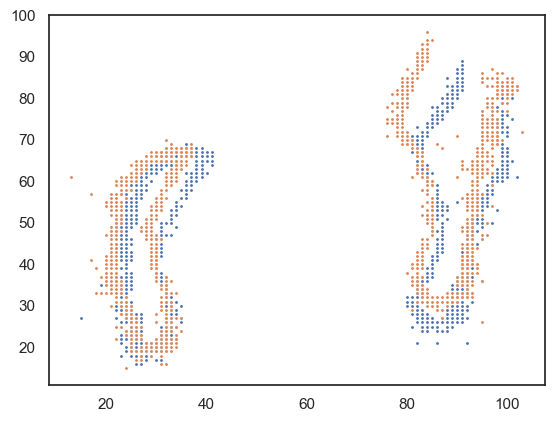

In [417]:
import seaborn as sns
sns.scatterplot(s=5,x=xs[:,0],y=xs[:,1])
sns.scatterplot(s=5,x=xt[:,0],y=xt[:,1])

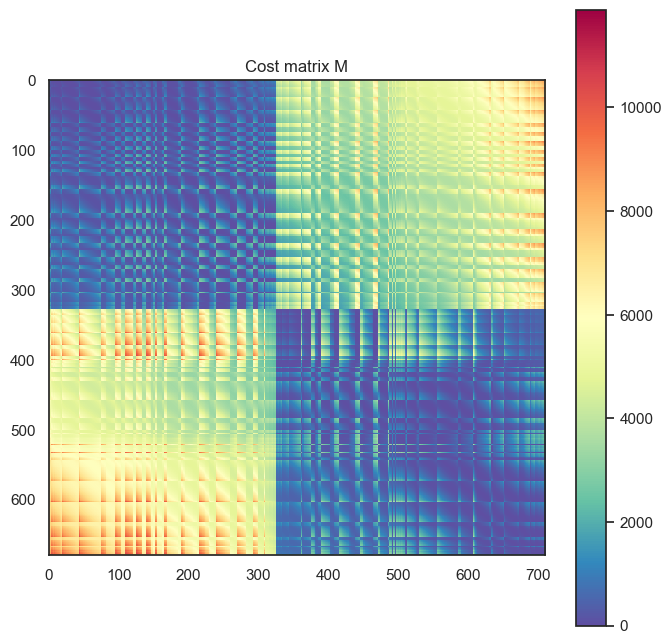

In [414]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(M, interpolation='nearest', cmap='Spectral_r')
plt.colorbar()
plt.title('Cost matrix M')
plt.savefig("./ot_matrix.eps", dpi=1000, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

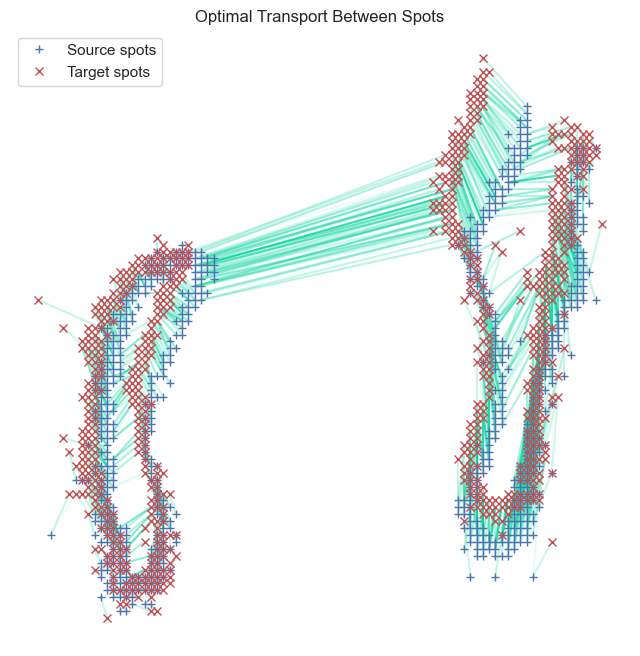

In [418]:
import ot.plot

G0 = ot.emd(a, b, M)

plt.figure(4)
plt.figure(figsize=(8, 8))
ot.plot.plot2D_samples_mat(xs, xt, 
                           G0, 
                           c='#06d6a0')
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source spots')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target spots')
plt.legend(loc=0)
plt.title('Optimal Transport Between Spots')
plt.axis('off')
plt.savefig("./ot.eps", dpi=1000, format='eps')

In [242]:
ot.emd2(a, b, M)

91.41040200162418

In [ ]:
gmm=get_gmm(sp.patterns_binary_matrix_dict[0],n_comp=20)
view_gmm(gmm,scope=(0,120))

In [ ]:
sp.plot.plot_genes(label=4, vmax=99,rotate=True,reverse_y=True)

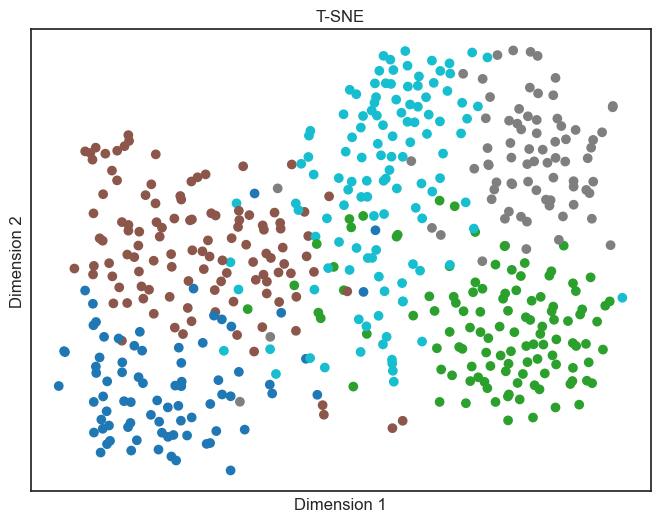

In [243]:
sp1.plot.plot_tsne()

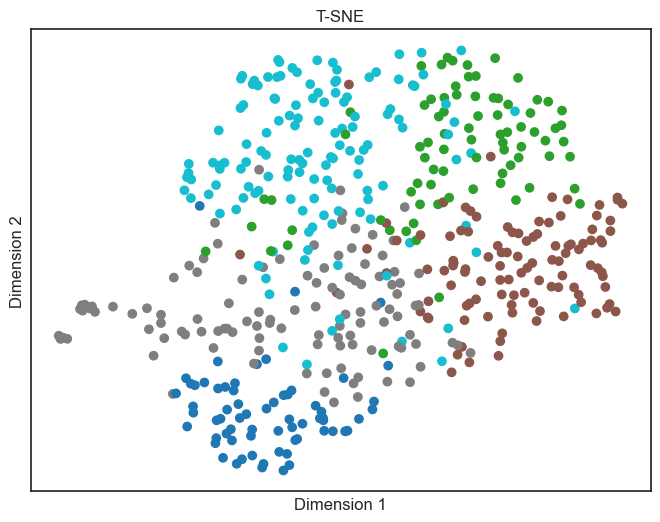

In [245]:
sp.plot.plot_tsne()

In [ ]:
from STMiner.Algorithm.distribution import compare_pattern

d = compare_pattern([sp,sp1,sp2], n_comp=5)

In [ ]:
from STMiner.Algorithm.distance import build_gmm_distance_array
a = build_gmm_distance_array(d)

In [ ]:
sp.plot.plot_genes(label=0)

In [ ]:
sp.plot.plot_intersection(pattern_list=[1,2],reverse_x=True,reverse_y=False, figsize=(8,8))

In [ ]:
sp.plot.plot_genes(label=3, vmax=95, plot_type='scatter', s=10, rotate=True)

In [ ]:
sp.plot.plot_tsne()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()

for i, center_i in enumerate(sp.kmeans_fit_result.cluster_centers_):
    graph.add_node(i)
    for j, center_j in enumerate(sp.kmeans_fit_result.cluster_centers_):
        if not graph.has_node(j):
            graph.add_node(j)
        if not graph.has_edge(i, j) and i != j:
            graph.add_edge(i, j, weight=np.linalg.norm(center_i - center_j))

pos = nx.spring_layout(graph, weight='weight')  # 布局算法，这里使用了Spring布局
nx.draw(graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_color='black',
        font_weight='bold')
edge_labels = nx.get_edge_attributes(graph, 'weight')
rounded_dict = {}
for key, value in edge_labels.items():
    rounded_value = round(1 / value, )  # 使用round函数保留三位小数
    rounded_dict[key] = rounded_value
nx.draw_networkx_edge_labels(graph, pos, edge_labels=rounded_dict)
plt.title("Network Visualization")
plt.show()


In [ ]:
from STMiner.node2vec import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt

import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()

for i, center_i in enumerate(sp.kmeans_fit_result.cluster_centers_):
    graph.add_node(i)
    for j, center_j in enumerate(sp.kmeans_fit_result.cluster_centers_):
        if not graph.has_node(j):
            graph.add_node(j)
        if not graph.has_edge(i, j) and i != j:
            graph.add_edge(i, j, weight=np.linalg.norm(center_i - center_j))


graph2 = nx.Graph()

for i, center_i in enumerate(a):
    graph2.add_node(i)
    for j, center_j in enumerate(a):
        if not graph2.has_node(j):
            graph2.add_node(j)
        if not graph2.has_edge(i, j) and i != j:
            graph2.add_edge(i, j, weight=np.linalg.norm(center_i - center_j))

node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, p=1, q=2)
node2vec2 = Node2Vec(graph2, dimensions=64, walk_length=30, num_walks=200, p=1, q=2)
# 训练模型
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = model.wv
arr = node_embeddings.vectors


model2 = node2vec2.fit(window=10, min_count=1, batch_words=4)
node_embeddings2 = model2.wv
arr2 = node_embeddings2.vectors

In [ ]:
import numpy as np
result = np.vstack((arr, arr2))
from sklearn.cluster import KMeans

fit_result = KMeans(n_clusters=6, random_state=0, max_iter=1000, n_init=20).fit(result)
fit_result.labels_

In [ ]:
sp.adata.var.index[0]

In [ ]:
arr2

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

with open('df.pkl', 'rb') as file:
    df = pickle.load(file)
sns.relplot(df, x='x', y='y', style='label', s=20)

In [ ]:
import seaborn as sns
sns.mpl_palette("viridis", as_cmap=True)

In [ ]:
sns.clustermap(sp.genes_distance_array)

In [ ]:
sp.plot.plot_tsne(method='umap')

In [ ]:
print("原本--------------------------------")
# CS: offset:10; under:0.1; p:0.8
print(656 / 700 * 100)
# MSE: offset:10; under:0.1; p:0.8
print(121 / 700 * 100)
# GMM: offset:10; under:0.1; p:0.8
print(700 / 700 * 100)

print("周期--------------------------------")
# CS: offset:10; under:0.1; p:0.8
print(572 / 700 * 100)
# MSE: offset:10; under:0.1; p:0.8
print(112 / 700 * 100)
# GMM: offset:10; under:0.1; p:0.8
print(700 / 700 * 100)

print("欠采样--------------------------------")
# CS: offset:10; under:0.1; p:0.8
print(639 / 700 * 100)
# MSE: offset:10; under:0.1; p:0.8
print(111 / 700 * 100)
# GMM: offset:10; under:0.1; p:0.8
print(700 / 700 * 100)

print("欠采样--------------------------------")
# CS: offset:10; under:0.1; p:0.8
print(568 / 700 * 100)
# MSE: offset:10; under:0.1; p:0.8
print(201 / 700 * 100)
# GMM: offset:10; under:0.1; p:0.8
print(676 / 700 * 100)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
categories = ['Zebrafish', 'Category B', 'Category C']
data1 = [100, 100, 100]
data2 = [93.71, 81.74, 91.29]
data3 = [17.29, 16, 15.86]
data4 = [14.29, 14.29, 14.29]

x = np.arange(len(categories))  # x轴坐标位置
width = 0.1  # 每个柱子的宽度

# 创建一个子图
fig, ax = plt.subplots()

# 绘制三个数据
ax.bar(x - width, data1, width, label='STMiner')
ax.bar(x, data2, width, label='SC')
ax.bar(x + width, data3, width, label='MSE')
ax.bar(x + width*2, data4, width, label='Random')

# 添加标签、标题和图例
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Bar Chart with Three Sets of Data')
ax.set_xticks(x)
ax.set_xticklabels(categories)
plt.axhline(y=100, color='red', linestyle='--', label="y=100")

# 显示图形
# plt.legend()
plt.show()


In [ ]:
import pandas as pd

df = pd.DataFrame([['Raw', 100, 'STMiner'],
                   ['Periodicity', 100, 'STMiner'],
                   ['Undersampling', 100, 'STMiner'],
                   ['Gauss', 96.57, 'STMiner'],
                   ['Raw', 17.29, 'MSE'],
                   ['Periodicity', 16, 'MSE'],
                   ['Undersampling', 15.86, 'MSE'],
                   ['Gauss', 28.71, 'MSE'],
                   ['Raw', 93.71, 'Cosine similarity'],
                   ['Periodicity', 81.74, 'Cosine similarity'],
                   ['Undersampling', 91.29, 'Cosine similarity'],
                   ['Gauss', 81.14, 'Cosine similarity'],
                   ['Raw', 14.29, 'Random'],
                   ['Periodicity', 14.29, 'Random'],
                   ['Undersampling', 14.29, 'Random'],
                   ['Gauss', 14.29, 'Random']],
                  columns=['type', 'accuracy', 'method'])
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] =42
mpl.rcParams['font.family'] = 'Arial'
sns.set_style("white")
sns.barplot(df,
            x='type',
            y='accuracy',
            hue='method',
            order=['Raw', 'Undersampling', 'Periodicity', 'Gauss'],
            hue_order=['STMiner', 'Cosine similarity', 'MSE', 'Random'],
            palette=['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2'])
plt.ylabel(None)
plt.xlabel(None)
plt.yticks(fontsize=15)
plt.xticks(fontsize=14)
plt.title('Accuracy',fontsize=17)
plt.savefig('Accuracy.eps',dpi=1000,format='eps')

In [ ]:
sp.genes_labels[sp.genes_labels['gene_id']=='BRAFhuman']

In [ ]:
sp.adata.var.loc['BRAFhuman']

In [ ]:
sp.plot.plot_pattern_1(vmax=99,
                     vote_rate=0.25,
                     heatmap=False,
                     s=10,
                     reverse_y=True,
                     reverse_x=True,
                     image_path='E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png',
                     rotate_img=True, 
                     k=4)

In [ ]:

with open('df.pkl', 'rb') as file:
    df = pickle.load(file)
df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

m = sns.relplot(df, x='x', y='y', col='label', col_wrap=4,cmap='viridis',palette='viridis',hue='c',hue_norm=plt.Normalize(0, 60))

for ax in m.axes:
    ax.axis('off')
    bg_img = mpimg.imread('E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png')
    bg_img = np.rot90(bg_img, k=4)
    ax.imshow(bg_img, extent=[0, df['x'].max(), 0, df['y'].max()], aspect=0.54)
plt.show()

In [ ]:
sp.plot.plot_genes(label=4, vmax=100, n_gene=20)

In [ ]:
sp.adata=adata

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
sp.plot.plot_gene('gene_P1_N', reverse_x=True, rotate=True)

In [ ]:
sp.genes_labels

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(sp.mds_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sp.kmeans_fit_result.labels_, cmap='tab10',s=10)
plt.title("t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Labels')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.savefig('tsne.eps', dpi=1000, format='eps')
plt.show()

In [ ]:
import umap
import matplotlib.pyplot as plt
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
embedded_data = umap_model.fit_transform(sp.mds_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sp.kmeans_fit_result.labels_,cmap='tab10')
plt.title("UMAP")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Labels')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
df = sp.compare_gene_to_genes('BRAFhuman')

In [ ]:
x_min = sp.adata.obsm['spatial_real'][:,1].min()
x_max = sp.adata.obsm['spatial_real'][:,1].max()
y_min = sp.adata.obsm['spatial_real'][:,0].min()
y_max = sp.adata.obsm['spatial_real'][:,0].max()
print(x_min, x_max, y_min,y_max)
print((y_max-y_min)/(x_max-x_min))

In [ ]:
from STMiner.Algorithm.distance import get_exp_array
from sklearn import mixture
from STMiner.Algorithm.distribution import array_to_list


def get_gmm(matrix, n_comp=10):
    arr = np.array(matrix, dtype=np.int32)
    result = array_to_list(arr)
    gmm = mixture.GaussianMixture(n_components=n_comp, max_iter=200).fit(result)
    return gmm


image = io.imread("E:/data/RegionC/RegionCplaqueHires.png")
cropped_image = cut_image(image)
resized = transform.resize(cropped_image, get_exp_array(adata, adata.var.index[0]).shape)
gaussian = filters.gaussian(resized, 3)
binary = np.where(gaussian > np.percentile(gaussian, 40), 1, 0)
gmm = get_gmm(binary, n_comp=20)

In [ ]:
x_min = sp.adata.obsm['spatial_real'][:,1].min()
x_max = sp.adata.obsm['spatial_real'][:,1].max()
y_min = sp.adata.obsm['spatial_real'][:,0].min()
y_max = sp.adata.obsm['spatial_real'][:,0].max()
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# 打开图像文件
image = Image.open("E://human/GSM4838132_Visium_B_image.tif/GSM4838132_Visium_B_image.tif")  # 替换为你的图像文件路径

# 使用crop方法进行剪裁
cropped_image = image.crop((x_min, y_min, x_max, y_max))

# 保存剪裁后的图像
cropped_image.save("cropped_image.tif")  # 保存为新的文件，也可以覆盖原始文件

In [ ]:
sp.fit_pattern(n_top_genes=500, n_comp=50, min_cells=200)
sp.build_distance_array()

In [ ]:
sp.cluster_gene(n_clusters=7, mds_components=20)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
index = pd.DataFrame([db,si,ch], index=['1/db','si','ch']).T
index_1 = (index-index.min()) / (index.max() - index.min())
sns.lineplot(index_1, markers=True)
plt.xticks(list(range(2, 12, 1)))
plt.xlabel("Number of Clusters")
plt.ylabel("Normalized Score")
plt.title("Evaluate Clustering Performance")
plt.show()

In [ ]:
sp.genes_distance_array.loc['frzb'].mean()

In [ ]:
df = pd.DataFrame(sp.genes_distance_array.mean(axis=1), columns=['mean'])
df = df.sort_values(by='mean', ascending=False)

In [ ]:
import seaborn as sns
sns.histplot(df)

In [ ]:
sp.genes_distance_array.loc['pax3a'].mean()

In [ ]:
from STMiner.Algorithm.distance import get_exp_array
from scipy.sparse import csr_matrix
import seaborn as sns

arr = get_exp_array(sp.adata, 'myl10')
arr = np.maximum(arr - np.mean(arr[arr != 0]), 0)
sparse_matrix = csr_matrix(arr)
sns.scatterplot(x=sparse_matrix.nonzero()[1],
                y=sparse_matrix.nonzero()[0],
                c=sparse_matrix.data
                )


In [ ]:
from matplotlib.transforms import Bbox
import matplotlib.pyplot as plt

# 创建一个2x2的子图网格
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# 绘制在所有子图中
axs[0, 0].plot([1, 2, 3, 4], [1, 2, 3, 4])
axs[0, 0].set_title('ss')

axs[0, 1].scatter([1, 2, 3, 4], [4, 3, 2, 1])
axs[0, 1].set_title('dd')

axs[1, 0].bar(['A', 'B', 'C', 'D'], [10, 20, 5, 15])
axs[1, 0].set_title('bb')

axs[1, 1].pie([30, 20, 25, 15], labels=['X', 'Y', 'Z', 'W'], autopct='%1.1f%%')
axs[1, 1].set_title('aa')

# 获取特定子图的位置
subplotspec = axs[0, 1].get_subplotspec()

# 使用subplotspec来创建新的坐标轴
new_ax = fig.add_axes(subplotspec.get_position(fig), frameon=False)

# 设置新坐标轴的内容
new_ax.plot([0, 1, 2, 3], [3, 4, 2, 1])


def full_extent(ax, pad=1):
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(pad, pad)


ax2 = plt.subplot(2,2,1)
extent = full_extent(ax2).transformed(fig.dpi_scale_trans.inverted())
new_ax.figure.savefig('specific_subplot.png', dpi=300, bbox_inches=extent, pad_inches=0)
